In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils

import MI
import tqdm
import bvcopula
import vine

In [2]:
animal = 'A0' #ST260 -> A0 for short
day_name = 'D1' # DayN -> DN
# data_type = 'Ca' # Ca or spikes+kernel
exp_pref = f'{animal}_{day_name}'
exp_postfix = 'gV' # given smth
path_models = f"{conf.path2outputs}/{exp_pref}_{exp_postfix}"
path_models

'/home/nina/outputs/A0_D1_gV'

In [3]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [4]:
models_lists = lambda n: f"{path_models}/models_layer{n}.pkl"
WAICs = vine.WAICs(models_lists)

[Errno 2] No such file or directory: '/home/nina/outputs/A0_D1_gV/models_layer20.pkl'
Loading stops and only the WAICs for lower trees are returned


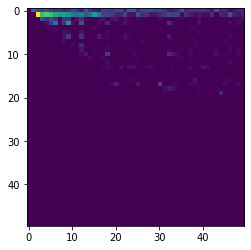

In [5]:
plt.imshow(-WAICs[:50,:50])

In [6]:
dataset_name = f"{conf.path2data}/ST260_Day1_standard.pkl"
X,Y = utils.standard_loader(dataset_name)
N_points = 200
train_x = torch.tensor(X, device='cuda:0').float()
train_x = train_x[torch.randperm(train_x.numel())[:N_points]]
weight_files = lambda layer,n: f"{path_models}/layer{layer}/model_{exp_pref}_{exp_postfix}_{layer}-{layer+n+1}.pth"

likelihoods, vine = vine.load(models_lists, weight_files, train_x)

In [7]:
# [len(copula_layers[i]) for i in range(108)]
copula_layers = vine.layers
c, c1 = 0, 0
for layer in copula_layers:
    for copulas in layer:
        c+= 1
        if len(copulas.copulas)==1:
            if copulas.copulas[0].__name__ == "IndependenceCopula":
                c1 += 1
print(c1,c,c1/c,c-c1)

4922 5356 0.9189693801344286 434


In [8]:
# with open(f"{home}/results/D1UxFU_vine.pkl","wb") as f:
#     pkl.dump([copula_layers,vine],f)
mc_size=2000
sem_tol = 0.1
%time entropy = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)

tensor(1.7577, device='cuda:0')
tensor(1.2350, device='cuda:0')
tensor(1.0039, device='cuda:0')
CPU times: user 3min 19s, sys: 103 ms, total: 3min 19s
Wall time: 3min 19s


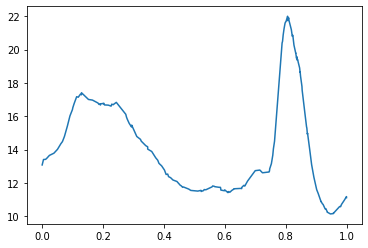

In [9]:
x = train_x.cpu().numpy()
order = np.argsort(x)
x = x[order]
y = -entropy.cpu().numpy()[order]
plt.plot(x,y)